In [73]:
import numpy as np
from sklearn.compose import ColumnTransformer
from scipy.special import boxcox1p
from scipy.stats import probplot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from category_encoders import *
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import EllipticEnvelope

#### 1. Load data

In [2]:
folderPath = "../data/"
train = pd.read_csv(folderPath + "train.csv")  
test = pd.read_csv(folderPath + "test.csv")  
print(train.shape)
train.head(2)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


#### 2. EDA
- Check missing data
- Check for outliers
- Create extra features (day of week)
- Check feature distributions
- Check target variable distribution
- Check correlation(s)

##### Missing data

In [3]:
def checkMissingData(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(10)

In [4]:
checkMissingData(train)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


- remove features with missing data > 40% & impute mean value into LotFrontage

In [5]:
train.drop(['PoolQC', 'MiscFeature', 'Alley', 'FireplaceQu', 'Fence'], axis=1, inplace = True)

- remove features with missing data > 40% & impute mean value into LotFrontage based on its own neighbourhood

In [7]:
# df_ = train.groupby(["Neighborhood"]).LotFrontage.mean()
# train[train.LotFrontage.isnull() == True].Neighborhood
# train['LotFrontage'].fillna(train['LotFrontage'].mean(), inplace=True)
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

In [8]:
checkMissingData(train)

,Total,Percent
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342


- 81 'Garage' variables are missing probably reflecting those houses without a garage
        - fill with 'NotAvail'

In [9]:
garage_cols = ['GarageType','GarageFinish', 'GarageCars','GarageQual', 'GarageCond']
train[garage_cols] = train[garage_cols].fillna('NotAvail')

- Recheck updated missing data

In [10]:
checkMissingData(train)

,Total,Percent
GarageYrBlt,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342
MasVnrArea,8,0.005479
MasVnrType,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000


- Scale GarageYrBlt to values between 0 and 1 and set missing values to '0' 
        - thereby having little influence as a feature as they are literally houses with no garage

In [13]:
X = train.values
ct = ColumnTransformer([("mm", MinMaxScaler(), ['GarageYrBlt'])])
train.GarageYrBlt = ct.fit_transform(train)
train.GarageYrBlt = train.GarageYrBlt.fillna(0)
checkMissingData(train)

,Total,Percent
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000
RoofStyle,0,0.000000


- The missing basement & MasVnr variables are for houses presumably without basements & masonry veneers: 
        - thereby having little influence as a feature as they are literally houses with no garage
        - use same method as before: type in "NotAvail"
        - replace missing electrical value with most common type

In [14]:
cols = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'BsmtCond', 'BsmtQual', 'MasVnrType']
train.MasVnrArea.fillna(value='NotAvail', inplace=True)
for col in cols:
    train[col].fillna(value='NotAvail', inplace=True)
train.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [15]:
#train[train['BsmtExposure']].fillna(value='NotAvail', inplace=True)
train.Electrical.fillna(value='SBrkr', inplace=True)
checkMissingData(train).head(1)

,Total,Percent
SalePrice,0,0.0


*No more missing data*

##### Visualise feature relationships with target variable

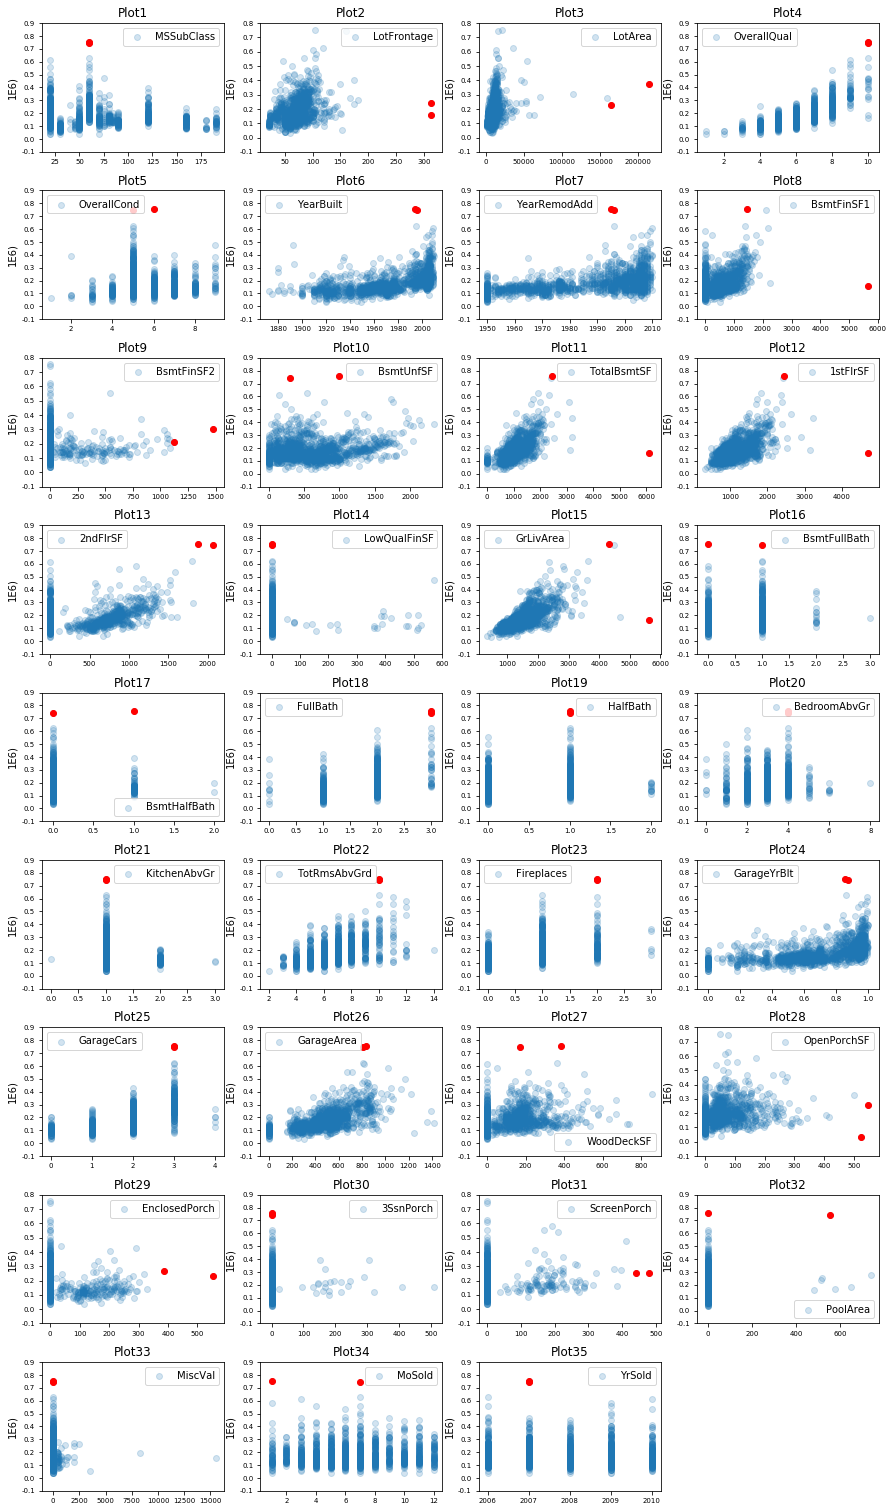

In [98]:
colList = []
count = 0
for i, col in enumerate(train.columns):
    if (i != 0) & ((train[col].dtype == 'int64') | (train[col].dtype == 'float64') ) & (col != 'SalePrice'):
        colList.append(col)
        count += 1

rows = int(np.ceil(len(colList) / 4))    # 4 plots per row
f = plt.figure(figsize=(15,3*rows))

for i, col in enumerate(colList):
    axi = f.add_subplot(rows, 4, i+1)
    plt.scatter(train[col], train.SalePrice, label = col, alpha = 0.2)
    df = train[[col, 'SalePrice']]
    X = df.values
    #cov = EllipticEnvelope(random_state=0).fit(X)
    elenv = EllipticEnvelope(contamination=.001)
    pred = elenv.fit_predict(X)
    anom_index = np.where(pred==-1)
    values = X[anom_index]

    #plt.scatter(X[:,0], X[:,1])
    plt.scatter(values[:,0],values[:,1], color='r')
    plt.title("Plot" + str(i+1))
    axi.tick_params(axis="x", labelsize=7)
    axi.tick_params(axis="y", labelsize=7)
    locs,labels = plt.yticks()
    plt.yticks(locs, map(lambda x: "%.1f" % x, locs/1e6))
    plt.ylabel('1E6)')
    plt.legend()
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

*Assuming a contamination of outliers in the dataset of 0.1% the above red datapoints have been suggested as outliers according to sklearn's "elliptic envelope"* <br> From the above plots it seems only appropriate to consider those in plots 2, 3, 8, 11, 12, 15, 28 & 33"  

In [97]:
# Plot2
train = train[(train.LotFrontage < 300)]# & (train.SalePrice > 200000)]
# Plot3
train = train[(train.LotArea < 150000)]# & (train.SalePrice > 200000)]
# Plot3
train = train[(train.BsmtFinSF1 < 5000)]# & (train.SalePrice > 200000)]    
# Plot3
train = train[(train.TotalBsmtSF < 5000)]# & (train.SalePrice > 200000)]    
# Plot3
train = train[(train['1stFlrSF'] < 5000)]# & (train.SalePrice > 200000)]    
                                          
              

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Attchd,0.981818,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,0,1,2008,New,Partial,160000


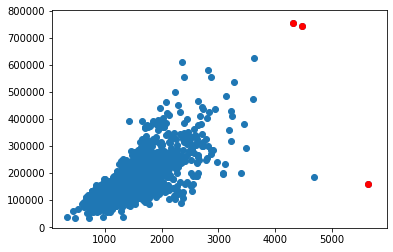

'\nprint(elenv)\n\nEllipticEnvelope(assume_centered=False, contamination=0.02, random_state=None,\n                 store_precision=True, support_fraction=None) \n\n\narr = cov.predict(X)\nplt.plot(arr, df.SalePrice)'

In [87]:
df = train[['GrLivArea', 'SalePrice']]
X = df.values
#cov = EllipticEnvelope(random_state=0).fit(X)
elenv = EllipticEnvelope(contamination=.002)
pred = elenv.fit_predict(X)


#Next, we'll extract the negative outputs as the outliers.

anom_index = np.where(pred==-1)
values = X[anom_index]


#Finally, we'll visualize the results in a plot by highlighting the anomalies with a color.

plt.scatter(X[:,0], X[:,1])
plt.scatter(values[:,0],values[:,1], color='r')
plt.show()

'''
print(elenv)

EllipticEnvelope(assume_centered=False, contamination=0.02, random_state=None,
                 store_precision=True, support_fraction=None) 


arr = cov.predict(X)
plt.plot(arr, df.SalePrice)'''

In [80]:
arr.shape

(1460,)

In [43]:
type(train.Id.dtype)

str

In [44]:
train.Id.dtype == 'int64'

True

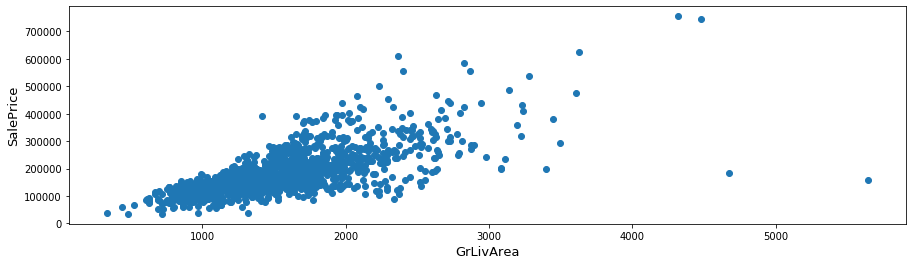

In [20]:
fig, ax = plt.subplots(figsize=(15,4))
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()